In [1]:
%load_ext autoreload
%autoreload 2

import fine_tune.train

import os
# set DATASET_DIRECTORY env var to "datasets/"
os.environ["DATASET_DIRECTORY"] = "datasets"

/home/andrewhealey/micromamba/envs/sam2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Segment Anything custom imported


In [2]:
cfg = None
dataset = None

In [3]:
from fine_tune.configs.solar_panels import *

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to datasets/panneau-dataset-47 in coco-segmentation:: 100%|██████████| 159/159 [00:00<00:00, 4386.80it/s]


In [4]:
assert cfg is not None,"Must set config"
assert dataset is not None,"Must set training dataset"

In [5]:
import torch
seed = 5
torch.manual_seed(seed)
import numpy as np
np.random.seed(seed)
import random
random.seed(seed)

In [6]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
from fine_tune.load_datasets import load_datasets

train_dataset,valid_dataset = load_datasets(cfg.data,dataset)

In [8]:
from fine_tune.models import WrappedSamModel

sam = WrappedSamModel(cfg).to(device)

encoder = sam.encoder
decoder = sam.decoder
predictor = sam.predictor

{}
warm started


In [9]:
import wandb
wandb.login()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: andrewhealey (roboflow2). Use `wandb login --relogin` to force relogin


True

In [10]:
import torch

run_num = None

if run_num is not None:
    sam.load_state_dict(torch.load(f"runs/{run_num}/trainable.pt"))

In [11]:
from fine_tune.load_datasets import prepare_torch_dataset

curr_dataset = prepare_torch_dataset(predictor,cfg,train_dataset,max_prompts=cfg.data.train_prompts)
valid_curr_dataset = prepare_torch_dataset(predictor,cfg,valid_dataset,max_prompts=cfg.data.valid_prompts)

  0%|          | 0/124 [00:00<?, ?it/s]

100%|██████████| 31/31 [00:00<00:00, 433411.41it/s]


In [12]:
class_counts = {i:0 for i in range(len(cfg.data.classes))}
for _,dets in train_dataset.annotations.items():
    # print num of each class of dets
    cls_ids = dets.class_id
    for cls_id in cls_ids:
        class_counts[cls_id] += 1
class_counts

{0: 0, 1: 10, 2: 187}

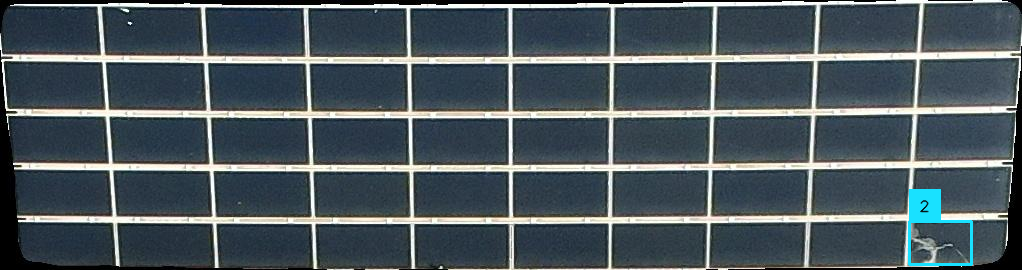

In [13]:
from fine_tune.viz import render_prompt
from random import randrange
import cv2

# print([prompt.box is not None for _,prompt in curr_dataset.prompts])

box_prompts = [(img_name,prompt) for img_name,prompt in curr_dataset.prompts if prompt.box is not None]

rand_img_name,rand_prompt = box_prompts[0]
rand_img = train_dataset.images[rand_img_name]

# save rand_img and rand_prompt to seqs/demo.png
render_prompt(rand_img,rand_prompt,train_dataset,predictor)

In [14]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.nn.functional import threshold, normalize

import cv2
import numpy as np

from numpy.random import permutation
from tqdm import tqdm
import json

from fine_tune.common import SamDataset,to
from fine_tune.interaction import get_max_iou_masks
from fine_tune.viz import mask_to_img,clip_together_imgs, show_confusion_matrix, render_prompt


In [15]:
from PIL import Image
import numpy as np

def evaluate():
    pred_classes = []
    gt_classes = []

    running_loss = 0.0
    running_count = 0

    running_cls_loss = 0.0
    running_cls_count = 0
    
    sam.eval()

    for batch in tqdm(valid_curr_dataset):

        batch = to(batch,device)
        prompt_input, gt_info, gt_cls_info, imgs,sizes, prompt = batch

        use_cls = cfg.model.decoder.use_cls and gt_cls_info is not None

        with torch.no_grad():
            encoder_output = encoder.get_decoder_input(imgs,prompt)

            low_res_masks, iou_predictions, cls_low_res_masks,cls_iou_predictions = pred = decoder(**prompt_input,**encoder_output)

            _,losses = decoder.loss(*pred, gt_info,gt_cls_info, sizes,prompt)

            normal_loss = losses["loss"]
            running_loss += normal_loss.item()
            running_count += 1

            cls_loss = losses["cls_loss"]
            running_cls_loss += cls_loss.item()
            running_cls_count += 1

            if use_cls:
                # get pred gt class
                (cls_upscaled_masks,cls_binary_masks), pred_cls = decoder.postprocess(cls_low_res_masks,cls_iou_predictions,sizes)

                _,_,_,best_cls,_ = get_max_iou_masks(gt_info["masks"],cls_binary_masks,gt_cls_info["gt_cls"],torch.arange(cfg.data.num_classes).to(device))

                pred_classes.append(pred_cls)
                gt_classes.append(best_cls)

    valid_loss = running_loss/running_count
    valid_cls_loss = running_cls_loss/running_cls_count

    print(f"VALID - Base loss: {valid_loss:.4f} - Class loss: {valid_cls_loss:.4f}")

    wandb.log({
        "valid_normal_loss": valid_loss,
        "valid_cls_loss": valid_cls_loss,
    })

    if len(gt_classes) > 0:
        # calculate confusion matrix
        show_confusion_matrix(gt_classes, pred_classes, class_names=valid_dataset.classes)


In [16]:
from fine_tune.optimizer import get_optimizer

optimizer,scheduler = get_optimizer(cfg,sam)

Total trainable parameters: 1366983


  0%|          | 0/572 [00:00<?, ?it/s]

100%|██████████| 572/572 [00:19<00:00, 29.07it/s]


VALID - Base loss: 2.2048 - Class loss: 9.9841


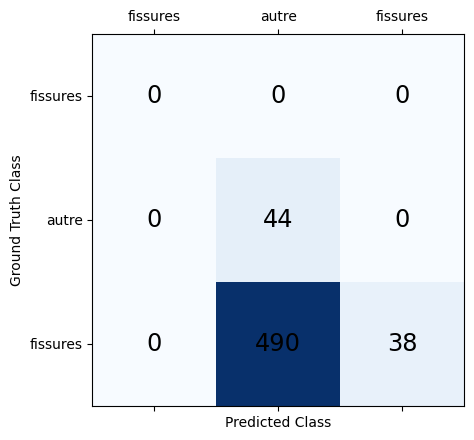

100%|██████████| 572/572 [00:17<00:00, 33.28it/s]


VALID - Base loss: 2.2048 - Class loss: 9.9841


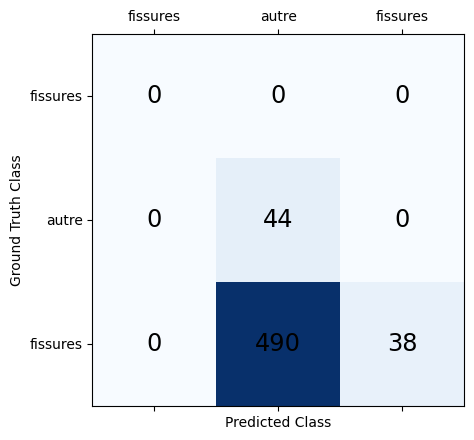

Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  0%|          | 0/2167 [00:17<?, ?it/s]


Loss: 2.8025619983673096


NotImplementedError: Need to update this to use new training system

In [17]:
from dataclasses import asdict

run = wandb.init(
    project="sam-fine-tune",
    config=asdict(cfg)
)

curr_iters = 0
accumulated_loss = 0

# track running avg of loss
recent_losses = []

curr_epoch = 0

# iter through dataset in random order
while curr_iters < cfg.train.max_steps:
    evaluate()
    sam.train()
    for i,idx in enumerate(tqdm(permutation(len(curr_dataset)))):

        with torch.no_grad():
            prompt_input, gt_info,gt_cls_info, imgs,sizes, prompt = batch = to(curr_dataset[idx],device)
        
        use_cls_loss = gt_cls_info is not None and cfg.model.decoder.use_cls
        
        has_fresh_prompt = True
        refinements_remaining = cfg.train.num_refinement_steps

        while has_fresh_prompt:
            has_fresh_prompt = False

            encoder_output = encoder.get_decoder_input(imgs,prompt)
            low_res_masks, iou_predictions, cls_low_res_masks,cls_iou_predictions = pred = decoder(**prompt_input,**encoder_output)


            #
            # WandB
            #
            
            loss,loss_dict = decoder.loss(*pred, gt_info,gt_cls_info, sizes,prompt)

            input_img_torch = imgs[2]
            image_embeddings= encoder_output["image_embeddings"]

            loss_dict = {k:v.item() for k,v in loss_dict.items()}
            wandb.log(loss_dict)

            #
            # Logging
            #

            recent_losses += [loss.item()]
            recent_losses = recent_losses[-cfg.train.log_period:]

            if curr_iters % cfg.train.eval_period == 0:
                evaluate()
                sam.train()

            if curr_iters % cfg.train.log_period == 0:
                print(f"Loss: {sum(recent_losses)/len(recent_losses)}")

            curr_iters += 1

            if not cfg.train.run_grad: continue

            accumulated_loss += loss
            if curr_iters % cfg.train.batch_size == 0:
                optimizer.zero_grad()
                accumulated_loss /= torch.tensor(cfg.train.batch_size,dtype=torch.float32)
                accumulated_loss.backward()
                optimizer.step()
                accumulated_loss = 0
            
            scheduler.step()

            #
            # Progressive refinement
            #

            if refinements_remaining > 0:

                raise NotImplementedError("Need to update this to use new training system")

                refinements_remaining -= 1

                has_fresh_prompt = True

    curr_epoch += 1

In [ ]:
sam.eval()
print("Model set to 'eval' mode - this means it will also compute normal (non-cls) predictions")

Model set to 'eval' mode - this means it will also compute normal (non-cls) predictions


In [ ]:
from glob import glob
import os

runs_dir = "runs_new"
run_ids = [int(fname) for fname in os.listdir(runs_dir)]
highest_run = max(run_ids) if len(run_ids) > 0 else 0
run_num = highest_run + 1
export_dir = f"{runs_dir}/{run_num}"
!mkdir -p $export_dir
print(f"Run saved to {export_dir}")

from fine_tune.export import export

export(export_dir,cfg,sam,device)

Run saved to runs_new/28
================ Diagnostic Run torch.onnx.export version 2.0.1 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



INFO:root:Quantization parameters for tensor:"/Sub_output_0" not specified
INFO:root:Quantization parameters for tensor:"mask_input" not specified
INFO:root:Quantization parameters for tensor:"/mask_downscaling/mask_downscaling.2/Mul_1_output_0" not specified
INFO:root:Quantization parameters for tensor:"/mask_downscaling/mask_downscaling.5/Mul_1_output_0" not specified
INFO:root:Quantization parameters for tensor:"/transformer/layers.0/Add_1_output_0" not specified
INFO:root:Quantization parameters for tensor:"/Concat_6_output_0" not specified
INFO:root:Quantization parameters for tensor:"/transformer/layers.0/self_attn/q_proj/w_a/MatMul_output_0" not specified
INFO:root:Quantization parameters for tensor:"/transformer/layers.0/self_attn/v_proj/w_a/MatMul_output_0" not specified
INFO:root:Quantization parameters for tensor:"/transformer/layers.0/self_attn/Reshape_3_output_0" not specified
INFO:root:Quantization parameters for tensor:"/transformer/layers.0/Add_output_0" not specified
I

Ignore MatMul due to non constant B: /[/transformer/layers.0/self_attn/MatMul]
Ignore MatMul due to non constant B: /[/transformer/layers.0/self_attn/MatMul_1]
Ignore MatMul due to non constant B: /[/transformer/layers.0/cross_attn_token_to_image/MatMul]
Ignore MatMul due to non constant B: /[/transformer/layers.0/cross_attn_token_to_image/MatMul_1]
Ignore MatMul due to non constant B: /[/transformer/layers.0/cross_attn_image_to_token/MatMul]
Ignore MatMul due to non constant B: /[/transformer/layers.0/cross_attn_image_to_token/MatMul_1]


INFO:root:Quantization parameters for tensor:"/transformer/layers.1/Add_2_output_0" not specified
INFO:root:Quantization parameters for tensor:"/transformer/layers.1/self_attn/q_proj/w_a/MatMul_output_0" not specified
INFO:root:Quantization parameters for tensor:"/transformer/layers.1/self_attn/v_proj/w_a/MatMul_output_0" not specified
INFO:root:Quantization parameters for tensor:"/transformer/layers.1/self_attn/Reshape_3_output_0" not specified
INFO:root:Quantization parameters for tensor:"/transformer/layers.1/Add_1_output_0" not specified
INFO:root:Quantization parameters for tensor:"/transformer/layers.1/cross_attn_token_to_image/q_proj/w_a/MatMul_output_0" not specified
INFO:root:Quantization parameters for tensor:"/transformer/layers.0/norm4/LayerNormalization_output_0" not specified
INFO:root:Quantization parameters for tensor:"/transformer/layers.1/cross_attn_token_to_image/v_proj/w_a/MatMul_output_0" not specified
INFO:root:Quantization parameters for tensor:"/transformer/laye

Ignore MatMul due to non constant B: /[/transformer/layers.1/self_attn/MatMul]
Ignore MatMul due to non constant B: /[/transformer/layers.1/self_attn/MatMul_1]
Ignore MatMul due to non constant B: /[/transformer/layers.1/cross_attn_token_to_image/MatMul]
Ignore MatMul due to non constant B: /[/transformer/layers.1/cross_attn_token_to_image/MatMul_1]
Ignore MatMul due to non constant B: /[/transformer/layers.1/cross_attn_image_to_token/MatMul]


INFO:root:Quantization parameters for tensor:"/transformer/layers.1/cross_attn_image_to_token/Reshape_3_output_0" not specified
INFO:root:Quantization parameters for tensor:"/transformer/Add_output_0" not specified
INFO:root:Quantization parameters for tensor:"/transformer/final_attn_token_to_image/q_proj/w_a/MatMul_output_0" not specified
INFO:root:Quantization parameters for tensor:"/transformer/layers.1/norm4/LayerNormalization_output_0" not specified
INFO:root:Quantization parameters for tensor:"/transformer/final_attn_token_to_image/v_proj/w_a/MatMul_output_0" not specified
INFO:root:Quantization parameters for tensor:"/transformer/final_attn_token_to_image/Reshape_3_output_0" not specified
INFO:root:Quantization parameters for tensor:"/Gather_8_output_0" not specified
INFO:root:Quantization parameters for tensor:"/cls_hypernetworks_mlps.2/Relu_output_0" not specified
INFO:root:Quantization parameters for tensor:"/cls_hypernetworks_mlps.2/Relu_1_output_0" not specified
INFO:root:Q

Ignore MatMul due to non constant B: /[/transformer/layers.1/cross_attn_image_to_token/MatMul_1]
Ignore MatMul due to non constant B: /[/transformer/final_attn_token_to_image/MatMul]
Ignore MatMul due to non constant B: /[/transformer/final_attn_token_to_image/MatMul_1]
Ignore MatMul due to non constant B: /[/MatMul_1]


  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:08<00:00, 23.19it/s]


VALID - Base loss: 0.3573 - Class loss: 0.5560


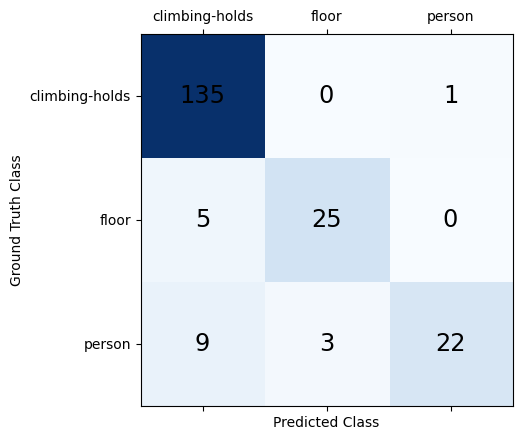

In [ ]:
evaluate()

Loss: 0.9535596966743469
Predicted IoU: 0.620735228061676 real IoU: 0.2298850566148758
Cls loss: 0.9471758008003235
Predicted cls: 2 GT cls: 2
Predicted cls IoU: 0.620735228061676 real cls IoU: 0.2298850566148758




                     GT Mask                      |          Normal Mask (not recommended)           |             Class Mask (recommended)             


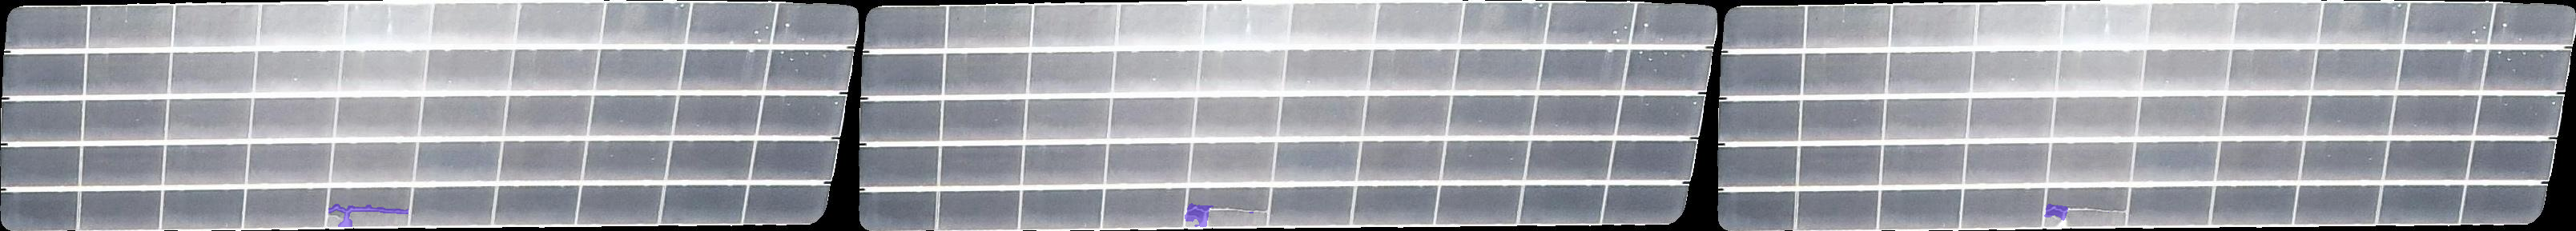

In [ ]:
from random import randint

sam.eval()
v_c_ds = valid_curr_dataset
idx = randint(0,len(v_c_ds)-1)

prompt_input, gt_info,gt_cls_info, imgs,sizes, prompt = batch = to(v_c_ds[idx],device)

gt_masks = gt_info["masks"]
gt_cls = gt_cls_info["gt_cls"]

use_normal_tokens = True
use_cls_tokens = cfg.model.decoder.use_cls and gt_cls_info is not None

has_fresh_prompt = True
num_refinements_left = cfg.train.num_refinement_steps
while has_fresh_prompt:
    has_fresh_prompt = False

    with torch.no_grad():
        encoder_output = encoder.get_decoder_input(imgs,prompt)
        low_res_masks, iou_predictions, cls_low_res_masks,cls_iou_predictions = pred = decoder(**prompt_input,**encoder_output)

        loss,losses = decoder.loss(*pred, gt_info,gt_cls_info, sizes,prompt)
        
        (upscaled_masks,binary_masks),max_idx = decoder.postprocess(low_res_masks,iou_predictions,sizes)
        pred_iou = F.sigmoid(iou_predictions[0,max_idx]).item()
        binary_mask = binary_masks[max_idx]

        gt_binary_mask, _, _, _, _ = get_max_iou_masks(gt_masks,binary_mask[None,...])

        if use_cls_tokens:

            (cls_upscaled_masks,cls_binary_masks), pred_cls = decoder.postprocess(cls_low_res_masks,cls_iou_predictions,sizes)
            cls_binary_mask = cls_binary_masks[pred_cls,...]

            # get focal and dice loss between cls_binary_mask and closest gt mask
            cls_gt_binary_mask,_,max_iou,best_cls,_ = get_max_iou_masks(gt_masks,cls_binary_masks,gt_cls,torch.arange(cfg.data.num_classes).to(device))

        if num_refinements_left > 0:
            raise NotImplementedError("Need to update this to use new training system")

            has_fresh_prompt = True
            num_refinements_left -= 1

from PIL import Image

img = imgs[0]


agg_img = mask_to_img(gt_binary_mask,img)

if use_normal_tokens:
    print("Loss:",losses["loss"].item())
    print("Predicted IoU:",pred_iou,"real IoU:",max_iou.item())

    normal_img = mask_to_img(binary_mask,img)
    # print(normal_img.shape)
    agg_img = clip_together_imgs(agg_img,normal_img)

# print cls loss
if use_cls_tokens:
    print("Cls loss:",losses["cls_loss"].item())
    print("Predicted cls:",pred_cls.item(),"GT cls:",gt_cls.item())
    print("Predicted cls IoU:",pred_iou,"real cls IoU:",max_iou.item())

    cls_img = mask_to_img(cls_binary_mask,img)
    agg_img = clip_together_imgs(agg_img,cls_img)


print("\n"*3)

# print 3 cols of 50 chars each, with title centered in each col
print(f"{'GT Mask':^50}|{'Normal Mask (not recommended)':^50}|{'Class Mask (recommended)':^50}")

agg_img

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to datasets/panneau-dataset-47 in coco-segmentation:: 100%|██████████| 159/159 [00:00<00:00, 4760.47it/s]


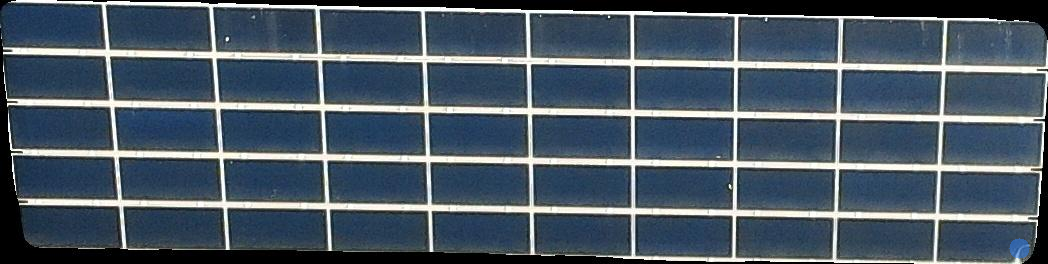

In [ ]:
from random import choice
import fine_tune.viz

name,prompt = choice(curr_dataset.prompts)
render_prompt(name,prompt,train_dataset,predictor)